In [10]:
import pandas as pd 
from selenobot.utils import DATA_DIR, SCRIPTS_DIR, dataframe_from_fasta, dataframe_to_fasta, dataframe_from_ko
from selenobot.extend import extend, translate
import os
import numpy as np
import subprocess
import time
from tqdm import tqdm 
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import warnings 
from selenobot.extend import extend
import sklearn
from typing import List
import wget
import itertools
import subprocess
import scipy
import argparse

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Set the main data directory to be the v3 validation directory. 
ORGANISM = 'acidovorax_3H11'
VAL_DIR = os.path.join(DATA_DIR, 'val3', ORGANISM) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
predictions_df = pd.read_csv(os.path.join(VAL_DIR, 'predictions.csv')) # Load selenoprotein predictions. 

print('Number of predicted selenoproteins:', np.sum(predictions_df.prediction.values))
print('Average length of predicted selenoproteins:', predictions_df[predictions_df.prediction == 1].seq.apply(len).mean())
print('Average length of predicted non-selenoproteins:', predictions_df[predictions_df.prediction == 0].seq.apply(len).mean()) 

Number of predicted selenoproteins: 55.0
Average length of predicted selenoproteins: 75.43636363636364
Average length of predicted non-selenoproteins: 318.8684049704624


## Extending predicted selenoproteins

In [ ]:
# Load the genome into a DataFrame which maps the scaffold ID to the scaffold sequence. 
# Complete genome sequences can be obtained from the organism home page on the Fitness Browser. 
genome_df = dataframe_from_fasta(os.path.join(VAL_DIR, 'genomes', f'{organism}.fna'))

In [6]:
df = pd.read_csv(os.path.join(VAL_DIR, 'acidovorax_3H11', 'embeddings.csv'), index_col=0).set_index('id')
df.to_csv(os.path.join(VAL_DIR, 'acidovorax_3H11', 'embeddings.csv'))
df.head()

,seq,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
id,,,,,,,,,,,,,,,,,,,,,
Ac3H11_1,VRAHLFHHGPLCGVTHFAAAPGRGFLHVLRRGEMVVTHQPQAGSPE...,-0.012147,-0.012879,-0.021039,0.003256,-0.027662,0.078276,0.028774,-0.063811,0.021661,...,0.034751,-0.013327,-0.001934,-0.053227,-0.008122,0.011662,-0.008071,-0.039997,0.010468,-0.000489
Ac3H11_2,VPDLQRFTTCKEITMSDHSSTARVALVDRTAASGPARALLDQIHGA...,0.009108,-0.048705,-0.036884,-0.011133,-0.007259,0.075528,0.017377,-0.058643,0.019812,...,-0.038920,-0.061925,0.035449,-0.063194,-0.048504,-0.030592,-0.063752,0.026394,0.017987,0.034035
Ac3H11_3,MPTATPAHAPQHASPRLPPLHAVRAFVSAARHLSFTRAAAELHVTH...,-0.023916,0.036147,0.014271,-0.005110,-0.045542,0.064133,-0.019674,-0.015267,0.006591,...,0.011067,-0.011304,-0.003387,-0.030146,0.008993,-0.029494,-0.029411,-0.042023,0.031659,0.039828
Ac3H11_4,MTEAPAPTDPHAIDTLQRLEALLGHPSDASLSKEVAYIHPAYRAMI...,-0.009450,0.059177,0.064567,-0.011430,-0.040270,0.042048,0.004669,-0.109072,0.014377,...,-0.018122,-0.024488,0.037411,-0.068160,0.018566,0.009159,-0.006478,0.023463,0.027254,0.054878
Ac3H11_5,MDSVLLIVAVGAVAAGFVQGLSGFGFGMVAMSFWAWSLEPRLAAVL...,0.017201,0.066138,0.037394,0.060369,-0.023225,0.011197,0.021962,-0.064155,0.001786,...,-0.008110,-0.008041,-0.030232,-0.055977,-0.046048,-0.047249,-0.050204,-0.051681,-0.009980,-0.020767


In [ ]:
stop_codons = set(extensions_df.stop_codon.values)
stop_codon_counts = {c:np.sum(extensions_df.stop_codon.values == c) for c in stop_codons}
print(stop_codon_counts)

{'TGA': 30, 'TAG': 17, 'TAA': 8}


In [ ]:
dataframe_to_fasta(extensions_df, f'{organism}.fa.ext')

## Analyzing fitness data

The fitness data is pretty noisy, so I am going to need to think of approaches which will limit the effect of the noise. 

One idea (from Josh) is to use the fitness value distribution for a specific feature (i.e. experimental condition) to generate p-values for (1) fitness value for transposon insertions within the predicted gene bounds (2) fitness values for transposon insertions in the extended region. Then I can compare the p-value distributions, maybe using KL divergence. 

In [ ]:
fitness_df = pd.read_csv(os.path.join(VAL_DIR, 'fitness', f'db.StrainFitness.{organism}'), delimiter='\t')
fitness_df.locusId = fitness_df.locusId.fillna('None')

In [ ]:
exps = [col for col in fitness_df.columns if col not in ['barcode', 'pos', 'scaffold', 'strand', 'locusId', 'used']]

In [ ]:
def filter_fitness_df(fitness_df:pd.DataFrame, start:int=None, stop:int=None, scaffold_id:str=None):
    '''Obtain fitness data for mutants where the inserted transposon lies within the specified region.'''
    fitness_df = fitness_df[fitness_df.scaffold.str.fullmatch(scaffold_id)]  # Get all entries on the same scaffold as the locus.
    # mask = np.logical_and(mask, fitness_df.strand == strand) # Get all entries on the same strand as the locus.
    fitness_df = fitness_df[(fitness_df.pos <= stop) & (fitness_df.pos >= start)] # Get all in-window mutations.

    # # Check to make sure filtering is correct. All locus ID values in the DataFrame should be NaN or the same. 
    # locus_ids = fitness_df.locusId.values
    # locus_ids = locus_ids[~pd.isnull(locus_ids)]
    # if len(locus_ids) > 0:
    #     locus_id = locus_ids[0]
    #     assert np.all(locus_ids == locus_id), 'get_fitness: All locus IDs in filtered fitness_df should be NaN or identical.'

    return fitness_df
    

def get_extension_window(start:int=None, stop:int=None, nt_ext:int=None, orientation:str=None, scaffold_id:str=None, **kwargs):
    '''Use the original start and stop locations, as well as the size of the extension, to get the window for the extension region of the
    predicted selenoprotein.'''
    if orientation == '-':
        ext_stop = stop 
        ext_start = start - nt_ext - 1 # Not 100 percent sure I should be subtracting one again, but I think so?
    if orientation == '+':
        ext_stop = stop + nt_ext
        ext_start = start 
    return {'start':ext_start, 'stop':ext_stop, 'scaffold_id':scaffold_id}



In [ ]:
# First, I want to get a sense of how many hits in the fitness DataFrame there are for each predicted selenoprotein.
n_hits = []
for row in extensions_df.itertuples(index=False):
    window = get_extension_window(**row._asdict())
    n_hits.append(len(filter_fitness_df(fitness_df, **window)))
extensions_df['n_hits'] = n_hits

In [ ]:
extensions_df.sort_values('n_hits', ascending=False).head()

,start,stop,orientation,seq,stop_codon,nt_ext,aa_ext,id,scaffold_id,n_hits
40,179034,182177,-,MLLAALGMAALGVISYQKLPIDAVPDITNVQVQINTQAAGYSPLET...,TAG,444,148,Ac3H11_4581,scaffold5/1,189
46,53766,54878,+,MLLPHTTKLIAASAYPSGGNAQFDSKPSKANRLLGFEQPAADGCNS...,TAA,39,13,Ac3H11_4888,scaffold5/30,177
17,1014017,1014253,+,MKKAPAWVTALMLMCFLAGADASGAAGFPEKPIKVVTPFTPGSAPD...,TAA,735,245,Ac3H11_2713,scaffold5/16,75
51,135817,135963,+,MILPQPGRACAGLRPVMLTGTLVRARREKRTVRAEPVEALRSASTG...,TGA,321,107,Ac3H11_4973,scaffold5/30,57
39,42129,42263,+,MWKGAEDWLHGDSGGLGSGPPGRGLILRRIVAEGVVMTERCCRGUF...,TGA,111,37,Ac3H11_45,scaffold5/5,51


In [ ]:
# Ac3H11_4581 = extensions_df[extensions_df['id'].str.match('Ac3H11_4581')].to_dict(orient='records')[0]
# Ac3H11_4581_window = get_extension_window(**Ac3H11_4581)
# filter_fitness_df(fitness_df, **Ac3H11_4581_window)


In [ ]:
def get_cofitness(extensions_df:pd.DataFrame, fitness_df:pd.DataFrame, id_:str='Ac3H11_4581', plot:bool=False, min_hits:int=5, min_rvalue:float=0.6):
    '''Compute the cofitness score between the in-gene and extension regions for predicted selenoproteins. The cofitness score is simply the R-value derived
    from fitting a line to the fitness data:

    :param extensions_df: A pandas DataFrame containing information 
    
    '''
    np.random.seed(42)
    
    # Extract the row from the extension_df for the specified locus ID as a dictionary. 
    row = extensions_df[extensions_df['id'].str.fullmatch(id_)].to_dict(orient='records')[0]
    fitness_df_filtered = filter_fitness_df(fitness_df, **get_extension_window(**row))
    fitness_df_gene = fitness_df_filtered[fitness_df_filtered.locusId.str.fullmatch(id_)] # Get the hits in the gene region. 
    fitness_df_ext = fitness_df_filtered[~fitness_df_filtered.locusId.str.fullmatch(id_)] # Get the hits in the extended gene region.

    fitness_df_nc = fitness_df[fitness_df.locusId.str.match('None')] # Get the hits in non-coding regions for the negative control.
    print('get_cofitness:', len(fitness_df_nc), 'non-coding hits in the entire fitness_df.')

    if (len(fitness_df_gene) < min_hits) or (len(fitness_df_ext) < min_hits):
        return None

    exps = filter_experiments(id_=id_)

    def get_points(x_df:pd.DataFrame, y_df:pd.DataFrame):
        # Remove all non-experiment columns. 
        # exclude_cols = ['barcode', 'scaffold', 'strand', 'locusId', 'pos', 'used']
        x_vals, y_vals = x_df[exps].values, y_df[exps].values
        x_errs = x_vals.std(axis=0) / np.sqrt(len(x_vals))
        y_errs = y_vals.std(axis=0) / np.sqrt(len(y_vals))
        return x_vals.mean(axis=0), y_vals.mean(axis=0), x_errs, y_errs
    
    # Interestingly, when I increase the number of control points, the R value increases. Is there a more intelligent way I can do the 
    # negative control? And why would increasing the number of points increase the correlation?
    def get_control_points(df:pd.DataFrame, n:int=None):
        ''''''
        idxs = np.arange(len(df))
        np.random.shuffle(idxs) 
        # Subset the random indices if a specific number is specified.
        idxs = idxs[:n] if int is not None else idxs
        idxs = np.array_split(idxs, 2)
        return get_points(df.iloc[idxs[0]], df.iloc[idxs[1]])

    # Get the main points for determining cofitness.
    x_vals, y_vals, _, _ = get_points(fitness_df_gene, fitness_df_ext)
    f = scipy.stats.linregress(x_vals, y_vals)
    
    # Get points for the positive control case, which are generated by randomly splitting the in-gene region into two parts.
    x_vals_ctrl_pos, y_vals_ctrl_pos, _, _ = get_control_points(fitness_df_gene)
    f_ctrl_pos = scipy.stats.linregress(x_vals_ctrl_pos, y_vals_ctrl_pos)

    # Get points for the negative control case, which are generated by randomly selecting samples from non-coding regions. 
    x_vals_ctrl_neg, y_vals_ctrl_neg, _, _ = get_control_points(fitness_df_nc)
    f_ctrl_neg = scipy.stats.linregress(x_vals_ctrl_neg, y_vals_ctrl_neg)
         
    if plot and (f_ctrl_pos.rvalue > min_rvalue) and (f.slope > 0):
        fig, ax = plt.subplots()
        ax.scatter(x_vals_ctrl_pos, y_vals_ctrl_pos, c='gray', alpha=0.3, s=4)
        ax.scatter(x_vals_ctrl_neg, y_vals_ctrl_neg, c='black', alpha=0.3, s=4)
        ax.scatter(x_vals, y_vals, c='tab:blue', alpha=0.3, s=4)
        # ax.errorbar(x_vals, y_vals, xerr=x_errs, yerr=y_errs, alpha=0.3, linestyle='')

        # Get the x-values for plotting linear regression lines.
        x_vals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1])

        ax.plot(x_vals, f_ctrl_pos.slope * x_vals + f_ctrl_pos.intercept, c='gray', linestyle='--', alpha=0.3)
        ax.plot(x_vals,f_ctrl_neg.slope * x_vals + f_ctrl_neg.intercept, c='black', linestyle='--', alpha=0.3)
        ax.plot(x_vals, f.slope * x_vals + f.intercept, c='tab:blue', linestyle='--')
        ax.legend(['in-gene control', 'non-coding region control', 'cofitness with extended region'], loc='upper left')

        ax.set_ylabel('fitness in extended region')
        ax.set_xlabel('fitness in gene')
        ax.set_title(f'Cofitness for gene {id_}')
        ax.text(0.9, 0.1, f'R={np.round(f.rvalue, 4)}', c='tab:blue', ha='right', va='bottom', transform=ax.transAxes)
        ax.text(0.9, 0.15, f'R={np.round(f_ctrl_pos.rvalue, 4)}', c='gray', ha='right', va='bottom', transform=ax.transAxes)
        ax.text(0.9, 0.2, f'R={np.round(f_ctrl_neg.rvalue, 4)}', c='black', ha='right', va='bottom', transform=ax.transAxes)
        plt.show()
    
    return abs(f.rvalue)


In [ ]:
# extensions_df[extensions_df.stop_codon == 'TGA'].sort_values('cofitness', ascending=False).head()

The plots below depict cofitness between the in-gene region and the downstream region (i.e. the region which is predicted to be missing if the gene is truncated). As a positive control, the in-gene fitness entries are randomly split into two groups and plotted relative to one another. This should have a correllation of close to one. As a negative control, a random subset of entries from non-coding regions are extracted from the dataset and plotted against one another. These should have correllation coefficient around zero.

get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitn

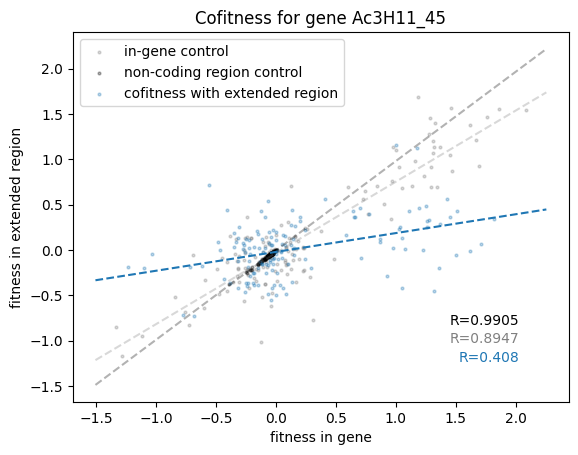

get_cofitness: 50171 non-coding hits in the entire fitness_df.


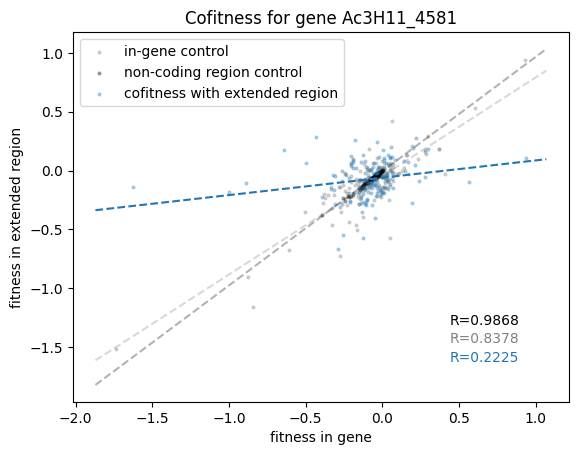

get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.
get_cofitness: 50171 non-coding hits in the entire fitness_df.


In [ ]:
cofitness = []
for id_ in extensions_df['id'].values:
    cofitness.append(get_cofitness(extensions_df, fitness_df, id_=id_, plot=True))
extensions_df['cofitness'] = cofitness
# extensions_df.sort_values('cofitness', ascending=False).head()

In [ ]:
get_cofitness(extensions_df, fitness_df, plot=True, id_='Ac3H11_1168')

In [ ]:
# TODO: Try splitting up in-gene observations and seeing if there is any correlation with those.
# TODO: In an attempt to reduce noise, try filtering using t-values. 
# TODO: Some kind of interference score to quantify how much of the downstream region is occupied by another gene.
# TODO: Compare to in-gene fitness values.
# TODO: Color-code experiment observations by category. 
# TODO: Maybe consider using the number of transposon mutations in the downstream region as a way to indicate if a region is useful?
# TODO: Maybe compare stop codon usage among hits to stop codon usage across the genome?